In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [4]:
def read_image(filename):
    '''
    read an image and return a tuple of
    (grayscale, black/white (binary) image)
    '''
    src = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    inverted = cv.bitwise_not(src)
    bw = cv.adaptiveThreshold(inverted, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, -2)
    return inverted, bw

In [6]:
def find_vertical_lines(bw, magic_number = 30):
    '''
    generates an image of the same shape as 'bw' where only the vertical lines remain.
    '''
    verticals = np.copy(bw)
    # Specify size on vertical axis
    rows, _ = verticals.shape
    # TODO: Smaller the magic number bigger the filtered out lines are
    # TODO: figure out how to find the optimal value
    vertical_size = rows // magic_number
    # Create structure element for extracting vertical lines through morphology operations
    vertical_structure = cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))
    # Apply morphology operations
    verticals = cv.erode(verticals, vertical_structure)
    verticals = cv.dilate(verticals, vertical_structure)
    return verticals

In [7]:
def find_horizontal_lines(bw, magic_number = 30):
    '''
    generates an image of the same shape as 'bw' where only the horizontal lines remain.
    '''
    horizontals = np.copy(bw)
    _, cols = horizontals.shape
    horizontal_size = cols // magic_number
    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
    # Apply morphology operations
    horizontals = cv.erode(horizontals, horizontalStructure)
    horizontals = cv.dilate(horizontals, horizontalStructure)
    return horizontals

In [8]:
def split_indices(array, comparator=(lambda x: x == 0)):
    '''Input: 1-D array of indicies of zeros of horizontal summation
    Output: Generator of indicies to split images by discontinuities in zeros'''
    indices = np.where(comparator(array))[0]
    # we dont want to add 1 to the index of the last element
    for i in range(indices.size - 1):
        if indices[i+1] - indices[i] != 1:
            yield (indices[i], indices[i+1])

def split_indices_average(array, comparator=(lambda x: x == 0)):
    '''Input: 1-D array of indicies of zeros of horizontal summation
    Output: Iterator of indicies to split image at by average of zeros'''
    line_pair = list(split_indices(array, comparator))
    line_pair = [(0, 0)] + line_pair + [(array.size-1, array.size-1)]
    for i in range(len(line_pair) - 2):
        a = line_pair[i][1]
        b = line_pair[i+1][0]
        a1 = line_pair[i+1][1]
        b1 = line_pair[i+2][0]
        yield ( a + ((b-a)//2) , a1 + ((b1-a1)//2))

In [9]:
def find_staves(gray_score, verticals, split_type = 'average', plot = False, save_as = None):
    '''
    params:
      split_type -- 'average' or 'strict'. 'average' takes the average
                    between where one staff is predicted to end and the
                    next is predicted to start. It classifies everything up
                    to that line as the first staff and everything after
                    that line as the second (so on and so forth for the
                    rest of the staves). 'strict' splits the staves by
                    where the each staff is predicted to start and end.
                    Another way to think of it is that 'average' guarantees
                    that if you stacked all of the split staves together,
                    you'd get the original image, whereas 'split' does not.
      plot    -- plot the image and location of split lines
      save_as -- the name of an image depicting where to split to get the staves
              (if plot is None, don't plot anything)
      imwrite -- use openCv to draw lines and save
    returns:
      an array of the rows to split at,
      an array of the separated staves of the score
    '''

    # normalize and find the horizontal sum of the vertical lines
    verts_norm = verticals // verticals.max()
    horiz_sum_verts = verts_norm.sum(axis=1)
    # tuples of (start,end) denoting where to split the image at
    staff_split_indices = None
    if split_type == 'average':
        staff_split_indices = list(split_indices_average(horiz_sum_verts))
    elif split_type == 'strict':
        staff_split_indices = list(split_indices(horiz_sum_verts))
    else:
        raise Exception('Invalid split_type given')

    # if told to, plot the source
    if plot:
        plt.figure(figsize=(10,13))
        plt.imshow(gray_score, aspect="auto", cmap = "gray")

    # split the score and verticals
    staves = []
    staves_verticals = []
    staves_start_end = staff_split_indices
    for (start, end) in staff_split_indices:
        staves.append(gray_score[start:end])
        staves_verticals.append(verticals[start:end])
        # if told to, plot the split lines
        if plot:
            plt.axhline(y=start, color='r')
            plt.axhline(y=end, color='r')

    # if told to, save the image
    if save_as is not None:
        plt.savefig('{}.png'.format(save_as))
        plt.clf()
    
    return staff_split_indices, staves

In [10]:
def fitStaffLines(scores, height, cutoff=0.9):
    N = len(scores)
    # idx_RH, idx_LH, best_score = 0, 0, -1
    # idxs_sorted = np.argsort(scores)[::-1]
    min_separation = int(height * 1.66)
    best_ind = np.argmax(scores)
    best_score = scores[best_ind]
    cutoff_score = best_score * cutoff
    indices_and_scores = [(score, index) for (index, score) in enumerate(scores) if score >= cutoff_score]
    valid_indices = []
    for score, index in sorted(indices_and_scores, reverse=True):
        if any(abs(index - i) <= min_separation for i in valid_indices):
            pass
        else:
            valid_indices.append(index)
    # for j in range(1, N):
    #     idx2 = idxs_sorted[j]
    #     curScore = scores[idx1] + scores[idx2]
    #     sep = np.abs(idx1 - idx2)
    #     if sep > min_separation and curScore > best_score:
    #         best_score = curScore
    #         idx_RH = min(idx1, idx2)
    #         idx_LH = max(idx1, idx2)
    #         break
    return best_score, valid_indices

In [24]:
def locateStaffLines(s, cutoff_percent = 0.5, min_height = 20, max_height = 300, plot = True):
    rsums = np.sum(s, axis=1)
    bestScore = 0
    lineLocs = []
    for h in range(min_height,max_height+1):
        idxs = h * np.arange(5) / 4.0
        idxs = idxs.round().astype('int')
        filt = np.zeros(h+1)
        filt[idxs] = 1 # create comb filter
        scores = np.convolve(rsums, filt, 'valid')
        curScore, indices = fitStaffLines(scores, h, cutoff_percent)
        if curScore > bestScore:
            bestScore = curScore
            lineLocs = [idxs + index for index in indices]
    
    if plot:
        plt.plot(rsums)
        for voice in lineLocs:
            for line in voice:
                plt.axvline(x=line, color='r', linewidth=1)
        plt.show()
        plt.figure(figsize=(10,13))
        plt.imshow(s, cmap='gray')
        for voice in lineLocs:
            for line in voice:
                plt.axhline(y=line, color='r', linewidth=1)
        plt.show()
        
    return lineLocs

In [20]:
filename = '113137.png'
#filename = '3-voice-test.png'

In [19]:
gray, bw = read_image(filename)

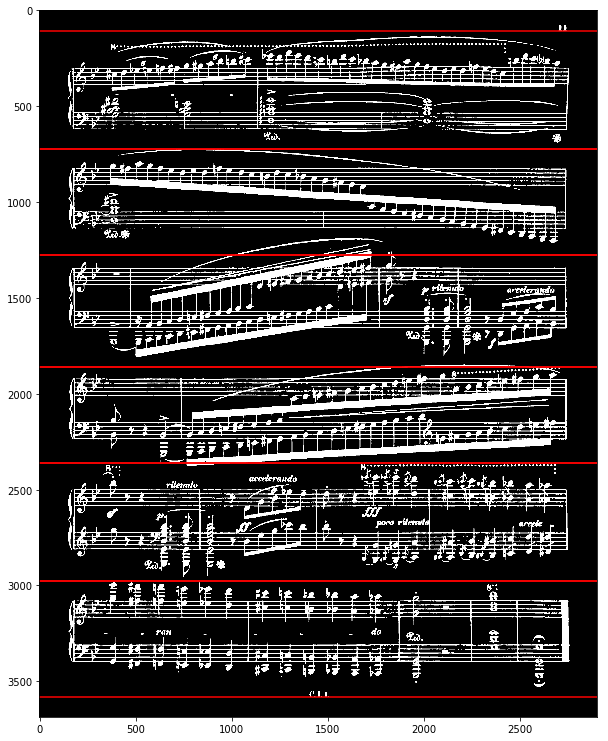

In [12]:
verticals = find_vertical_lines(bw)
horizontals = find_horizontal_lines(bw)
indices, staves = find_staves(gray, verticals, split_type = 'average', plot = True)
horizontal_staves = [horizontals[start:end] for start, end in indices]

In [13]:
[staff.shape for staff in staves]

[(617, 2903), (550, 2903), (587, 2903), (501, 2903), (614, 2903), (604, 2903)]

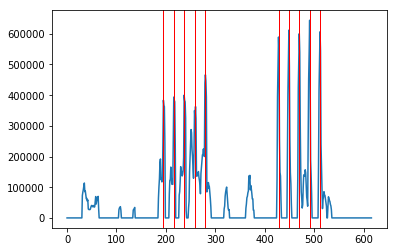

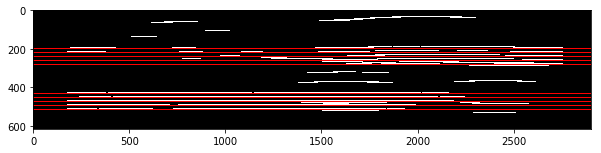

[array([428, 449, 470, 491, 512]), array([195, 216, 237, 258, 279])]

In [25]:
locateStaffLines(horizontal_staves[0])

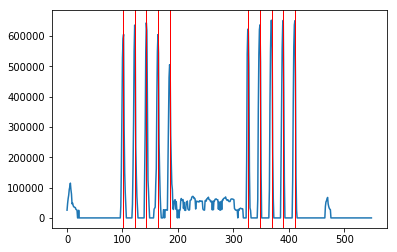

array([327, 348, 369, 390, 411, 101, 122, 143, 164, 185])

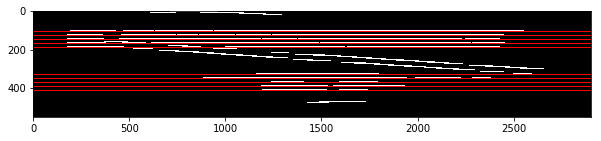

In [15]:
locateStaffLines(horizontal_staves[1])

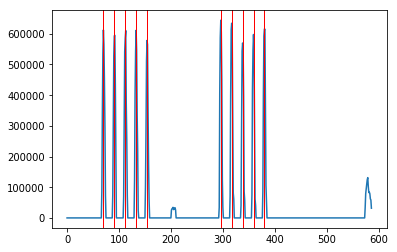

array([296, 317, 338, 359, 380,  70,  91, 112, 133, 154])

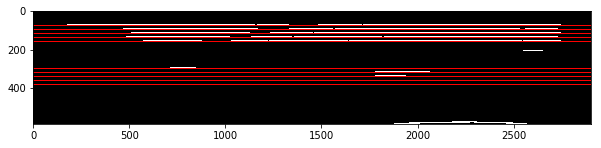

In [16]:
locateStaffLines(horizontal_staves[2])

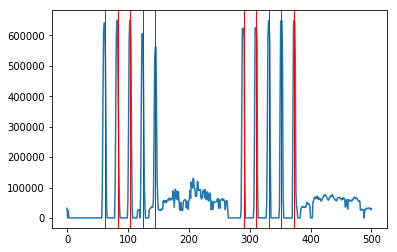

array([290, 311, 332, 352, 373,  62,  83, 104, 124, 145])

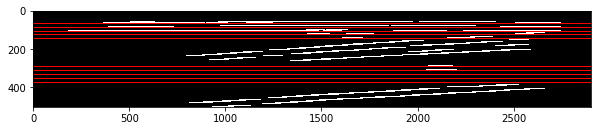

In [17]:
locateStaffLines(horizontal_staves[3])

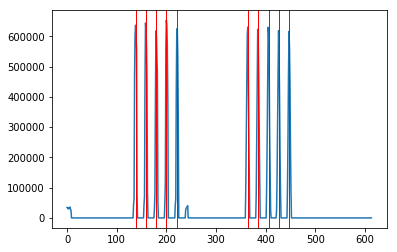

array([138, 159, 180, 200, 221, 364, 385, 406, 426, 447])

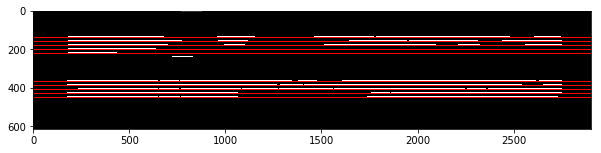

In [18]:
locateStaffLines(horizontal_staves[4])